## Walkthrough of (py)LDAvis computations
### Read a Test Corpus

In [31]:
import gensim
import scipy
import numpy as np
import pandas as pd

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

### Prepare a Small Test Corpus

In [32]:
with open('test_corpus.txt', 'r') as f:
    text = f.read()

corpus = [ line.split(' ') for line in text.split('\n')]
   
print(text)

computer human interface
computer response survey system time user
interface system user eps
human system system eps
response time user
trees
trees graph
trees graph minors
survey graph minors


### Create gensim Dictionary and BoW-corpus

In [33]:
dictionary = gensim.corpora.Dictionary(corpus)
bow_corpus = [ dictionary.doc2bow(d) for d in corpus ]

_ = dictionary[0] # Force load of lazy id2token property

_vocab = list(dictionary.id2token.values())
vocab  = pd.Series(_vocab, name='vocab')

' '.join(vocab)

R = min(30, len(vocab))


'computer human interface response survey system time user eps trees graph minors'

### Compute Global Word Frequencies and Document Lengths

In [34]:
corpus_csc = gensim.matutils.corpus2csc(bow_corpus, num_terms=len(dictionary))

# Word frequencies are the sum each row (axis=1). Convert to array (.A) and flatten (.ravel)
_term_frequency = corpus_csc.sum(axis=1).A.ravel().astype(int)
term_frequency  = pd.Series(_term_frequency, name='term_frequency')

# Document lengths are the sum each column (axis=0). Convert to array (.A) and flatten (.ravel)
_doc_lengths = corpus_csc.sum(axis=0).A.ravel().astype(int)
doc_lengths  = pd.Series(_doc_lengths, name='doc_length')

term_frequency.to_dict()
doc_lengths.to_dict()

{0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 4, 6: 2, 7: 3, 8: 2, 9: 3, 10: 3, 11: 2}

{0: 3, 1: 6, 2: 4, 3: 4, 4: 3, 5: 1, 6: 2, 7: 3, 8: 3}

### Compute an LDA Topic Model

In [35]:
topic_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, iterations=2000, num_topics=4, alpha='auto')
topic_model.show_topics(num_words=5, log=False, formatted=True)

[(0,
  '0.160*"survey" + 0.158*"graph" + 0.090*"time" + 0.090*"user" + 0.090*"computer"'),
 (1,
  '0.191*"system" + 0.132*"user" + 0.132*"interface" + 0.132*"human" + 0.131*"eps"'),
 (2,
  '0.310*"trees" + 0.178*"graph" + 0.177*"minors" + 0.039*"system" + 0.037*"user"'),
 (3,
  '0.094*"trees" + 0.086*"graph" + 0.084*"system" + 0.083*"eps" + 0.082*"human"')]

### Compute Document Topic Distribution (Gamma)

In [36]:
def compute_doc_topic_dists(topic_model, bow_corpus):
    '''Returns normalized document-topic distributions.
    
    The `gamma` is the document-topic (multinominal) distributions infered from model for the bow-corpus
    '''
    gamma, _ = topic_model.inference(bow_corpus)       # Apply model to corpus, get gamma-values
    row_sums_as_column = gamma.sum(axis=1)[:, None]    # Compute row-sums, transpose sums to a column
    _dists = gamma / row_sums_as_column                # Normalize weights for each document i.e. divide each row by row-sum
    
    # Alt #1: assumes result sorted by topic_id
    #  np.array([ [ w for _, w in x] for x in topic_model[bow_corpus] ]) 
    
    # Alt #2:
    # w, i, j = tuple(zip(*[ (w, i, j) for i, doc in enumerate(topic_model[bow_corpus]) for j, w in doc]))
    # doc_topic_dists = scipy.sparse.coo_matrix((w,(i,j))).tocsc()

    return _dists

_doc_topic_dists = compute_doc_topic_dists(topic_model, bow_corpus)

doc_topic_dists = pd.DataFrame(_doc_topic_dists).rename_axis('doc').rename_axis('topic', axis=1)
doc_topic_dists

topic,0,1,2,3
doc,,,,
0,0.065938,0.841487,0.053300,0.039275
1,0.898677,0.049045,0.030101,0.022177
2,0.051729,0.874648,0.042386,0.031238
3,0.051542,0.874837,0.042383,0.031237
4,0.069964,0.837435,0.053319,0.039282
5,0.134328,0.149040,0.635827,0.080805
6,0.090917,0.097492,0.758739,0.052852
7,0.066986,0.072434,0.821313,0.039267
8,0.832935,0.072458,0.055334,0.039272


## Compute Topic Term Distributions (Lambda)

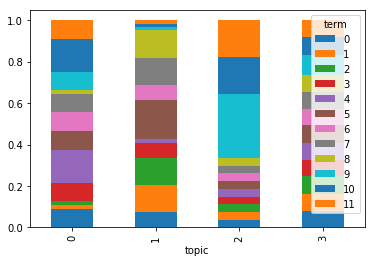

In [37]:
def compute_topic_term_dists(topic_model, bow_corpus):
    
    _dists = topic_model.state.get_lambda()
    _dists = _dists / _dists.sum(axis=1)[:, None]
    
    return _dists

_topic_term_dists = compute_topic_term_dists(topic_model, bow_corpus)

topic_term_dists = pd.DataFrame(_topic_term_dists).rename_axis('topic').rename_axis('term', axis=1)
topic_term_dists.plot(kind='bar', stacked=True)

## Compute Global (Marginal) Topic Proportions 

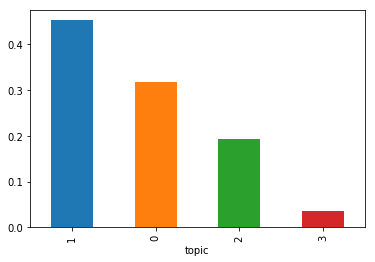

In [38]:
topic_freq       = (doc_topic_dists.T * doc_lengths).T.sum()
topic_proportion = (topic_freq / topic_freq.sum())

if True: #(sort_topics):
    topic_proportion  = topic_proportion.sort_values(ascending=False)
    # reorder all data based on new ordering of topics
    topic_freq       = topic_freq[topic_proportion.index]
    topic_term_dists = topic_term_dists.iloc[topic_proportion.index]
    doc_topic_dists  = doc_topic_dists[topic_proportion.index]

topic_proportion.plot(kind='bar')

## Compute Term Frequencies (Global and per Topic)
Topic-term distributions are weighed by topic frequencies.

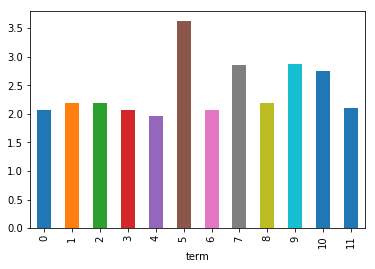

In [39]:
# token counts for each term-topic combination (widths of red bars)
term_topic_freq = (topic_term_dists.T * topic_freq).T
term_frequency  = np.sum(term_topic_freq, axis=0)     # note! recalculation, see comment
term_frequency.plot(kind='bar')

## Compile Topic Top Terms (Over 0.0 < Lambda < 1.0)
Parallellism removed for simplicity

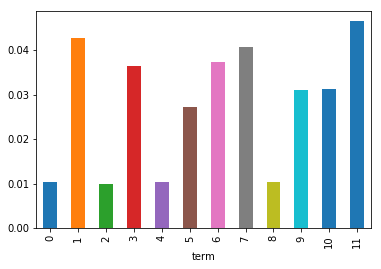

In [10]:
def compute_saliency(topic_term_dists, topic_proportion, term_proportion):
    # compute the distinctiveness and saliency of the terms:
    # this determines the R terms that are displayed when no topic is selected
    topic_given_term = topic_term_dists / topic_term_dists.sum()
    kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
    distinctiveness = kernel.sum()
    saliency = term_proportion * distinctiveness
    return distinctiveness, saliency

# Marginal distribution over terms (width of blue bars)
term_proportion = term_frequency / term_frequency.sum()

distinctiveness, saliency = compute_saliency(topic_term_dists, topic_proportion, term_proportion)
display(saliency.plot(kind='bar'))
#display(distinctiveness.plot(kind='bar'))

In [11]:
def default_relevance(saliency, term_frequency):

    # Order the terms for the "default" view by decreasing saliency:
    ranks = np.arange(R, 0, -1)
    default_term_info  = pd.DataFrame({
        'saliency': saliency,
        'Term': vocab,
        'Freq': np.floor(term_frequency),
        'Total': np.floor(term_frequency),
        'Category': 'Default'
    }).sort_values(by='saliency', ascending=False)\
      .head(R)\
      .drop('saliency', 1)\
      .assign(logprob=ranks, loglift=ranks)
    
    return default_term_info
    
default_relevance(saliency, term_frequency)

,Category,Freq,Term,Total,loglift,logprob
term,,,,,,
11,Default,2.0,minors,2.0,12,12
1,Default,2.0,human,2.0,11,11
7,Default,2.0,user,2.0,10,10
6,Default,1.0,time,1.0,9,9
3,Default,1.0,response,1.0,8,8
10,Default,3.0,graph,3.0,7,7
9,Default,2.0,trees,2.0,6,6
5,Default,3.0,system,3.0,5,5
8,Default,2.0,eps,2.0,4,4


In [42]:
def _find_relevance(log_ttd, log_lift, R, lambda_):
    relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift
    return relevance.T.apply(lambda s: s.sort_values(ascending=False).index).head(R)

log_lift = np.log(topic_term_dists / term_proportion)
log_ttd = np.log(topic_term_dists)
lambda_step = 0.01
lambda_seq = np.arange(0, 1 + lambda_step, lambda_step)

# Get the top terms for each topic & lambda-value...
_top_terms = [_find_relevance(log_ttd, log_lift, R, l) for l in lambda_seq]
top_terms = pd.concat(_top_terms)
# Extract the unique top-terms for each topic...
top_terms.unstack().reset_index().groupby('topic').apply(lambda x: list(set(x[0])))
#top_terms
#len(_top_terms)
#len(top_terms)
#top_terms.T
#    top_terms = pd.concat([_find_relevance(log_ttd, log_lift, R, l) for l in lambda_seq])
#    print(len(top_terms))
#    topic_dfs = map(topic_top_term_df, enumerate(top_terms.T.iterrows(), 1))
#    return pd.concat([default_term_info] + list(topic_dfs), sort=True)


topic
0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
1    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
2    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
3    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
dtype: object

In [44]:
lambda_ = 0.31
lambda_ * log_ttd + (1 - lambda_) * log_lift

term,0,1,2,3,4,5,6,7,8,9,10,11
topic,,,,,,,,,,,,
1,-0.802263,-0.219274,-0.212706,-0.745762,-2.424475,-0.194691,-0.747527,-0.361436,-0.214437,-2.480357,-2.607893,-2.456053
0,-0.598118,-2.180707,-2.172848,-0.544654,-0.075438,-0.950017,-0.537038,-0.748419,-2.163779,-0.804860,-0.309624,-0.719530
2,-1.476641,-1.488489,-1.484530,-1.417493,-1.539844,-1.785764,-1.421395,-1.622796,-1.483567,0.437028,-0.192778,-0.030695
3,-0.693148,-0.688535,-0.685293,-0.631797,-0.752811,-1.015485,-0.637752,-0.847513,-0.679171,-0.755943,-0.918313,-0.797964


In [30]:
def _find_relevance(log_ttd, log_lift, R, lambda_):
    relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift
    return relevance.T.apply(lambda s: s.sort_values(ascending=False).index).head(R)

def _topic_info(topic_term_dists, topic_proportion, term_frequency, term_topic_freq, vocab, lambda_step, R, n_jobs):
    
    # marginal distribution over terms (width of blue bars)
    term_proportion = term_frequency / term_frequency.sum()
    _, saliency = compute_saliency(topic_term_dists, topic_proportion, term_proportion)

    # Order the terms for the "default" view by decreasing saliency:
    default_term_info  = default_relevance(saliency, term_frequency)

    ## compute relevance and top terms for each topic
    log_lift = np.log(topic_term_dists / term_proportion)
    log_ttd = np.log(topic_term_dists)
    
    lambda_seq = np.arange(0, 1 + lambda_step, lambda_step)

    def topic_top_term_df(tup):
        new_topic_id, (original_topic_id, topic_terms) = tup
        term_ix = topic_terms.unique()
        return pd.DataFrame({
            'Term': vocab[term_ix],
            'Freq': term_topic_freq.loc[original_topic_id, term_ix],
            'Total': term_frequency[term_ix],
            'logprob': log_ttd.loc[original_topic_id, term_ix].round(4),
            'loglift': log_lift.loc[original_topic_id, term_ix].round(4),
            'Category': 'Topic%d' % new_topic_id
        })

    #top_terms = pd.concat(
    #    Parallel(n_jobs=n_jobs)(
    #        delayed(_find_relevance_chunks)(log_ttd, log_lift, R, ls) for ls in _job_chunks(lambda_seq, n_jobs)
    #    )
    #)
    #top_terms2 = pd.concat(_find_relevance_chunks(log_ttd, log_lift, R, ls) for ls in _job_chunks(lambda_seq, n_jobs))
    #top_terms3 = _find_relevance_chunks(log_ttd, log_lift, R, lambda_seq)

    top_terms = pd.concat([_find_relevance(log_ttd, log_lift, R, l) for l in lambda_seq])
    print(len(top_terms))
    topic_dfs = map(topic_top_term_df, enumerate(top_terms.T.iterrows(), 1))
    return pd.concat([default_term_info] + list(topic_dfs), sort=True)

lambda_step = 0.01
n_jobs = 4
topic_info  = _topic_info(topic_term_dists, topic_proportion, term_frequency, term_topic_freq, vocab, lambda_step, R, n_jobs)

topic_info

1212


,Category,Freq,Term,Total,loglift,logprob
term,,,,,,
11,Default,2.000000,minors,2.000000,12.0000,12.0000
1,Default,2.000000,human,2.000000,11.0000,11.0000
7,Default,2.000000,user,2.000000,10.0000,10.0000
6,Default,1.000000,time,1.000000,9.0000,9.0000
3,Default,1.000000,response,1.000000,8.0000,8.0000
10,Default,3.000000,graph,3.000000,7.0000,7.0000
9,Default,2.000000,trees,2.000000,6.0000,6.0000
5,Default,3.000000,system,3.000000,5.0000,5.0000
8,Default,2.000000,eps,2.000000,4.0000,4.0000


In [64]:
token_table        = _token_table(topic_info, term_topic_freq, vocab, term_frequency)


def _token_table(topic_info, term_topic_freq, vocab, term_frequency):
   # last, to compute the areas of the circles when a term is highlighted
   # we must gather all unique terms that could show up (for every combination
   # of topic and value of lambda) and compute its distribution over topics.

   # term-topic frequency table of unique terms across all topics and all values of lambda
   term_ix = topic_info.index.unique()
   term_ix = np.sort(term_ix)

   top_topic_terms_freq = term_topic_freq[term_ix]
   # use the new ordering for the topics
   K = len(term_topic_freq)
   top_topic_terms_freq.index = range(1, K + 1)
   top_topic_terms_freq.index.name = 'Topic'

   # we filter to Freq >= 0.5 to avoid sending too much data to the browser
   token_table = pd.DataFrame({'Freq': top_topic_terms_freq.unstack()}). \
                 reset_index().set_index('term'). \
                 query('Freq >= 0.5')

   token_table['Freq'] = token_table['Freq'].round()
   token_table['Term'] = vocab[token_table.index.values].values
   # Normalize token frequencies:
   token_table['Freq'] = token_table.Freq / term_frequency[token_table.index]
   return token_table.sort_values(by=['Term', 'Topic'])

In [64]:
topic_coordinates  = _topic_coordinates(mds, topic_term_dists, topic_proportion)

#return PreparedData(topic_coordinates, topic_info, token_table, R, lambda_step)

NameError: name '_topic_info' is not defined

In [65]:
"""
pyLDAvis Prepare
===============
Main transformation functions for preparing LDAdata to the visualization's data structures
"""

from past.builtins import basestring
from collections import namedtuple
import json
import logging
from joblib import Parallel, delayed, cpu_count
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
#from .utils import NumPyEncoder
try:
    from sklearn.manifold import MDS, TSNE
    sklearn_present = True
except ImportError:
    sklearn_present = False


def __num_dist_rows__(array, ndigits=2):
   return array.shape[0] - int((pd.DataFrame(array).sum(axis=1) < 0.999).sum())


class ValidationError(ValueError):
   pass


def _input_check(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency):
   ttds = topic_term_dists.shape
   dtds = doc_topic_dists.shape
   errors = []
   def err(msg):
      errors.append(msg)

   if dtds[1] != ttds[0]:
      err('Number of rows of topic_term_dists does not match number of columns of doc_topic_dists; both should be equal to the number of topics in the model.')

   if len(doc_lengths) != dtds[0]:
      err('Length of doc_lengths not equal to the number of rows in doc_topic_dists; both should be equal to the number of documents in the data.')

   W = len(vocab)
   if ttds[1] != W:
      err('Number of terms in vocabulary does not match the number of columns of topic_term_dists (where each row of topic_term_dists is a probability distribution of terms for a given topic).')
   if len(term_frequency) != W:
      err('Length of term_frequency not equal to the number of terms in the vocabulary (len of vocab).')

   if __num_dist_rows__(topic_term_dists) != ttds[0]:
      err('Not all rows (distributions) in topic_term_dists sum to 1.')

   if __num_dist_rows__(doc_topic_dists) != dtds[0]:
      err('Not all rows (distributions) in doc_topic_dists sum to 1.')

   if len(errors) > 0:
      return errors


def _input_validate(*args):
   res = _input_check(*args)
   if res:
      raise ValidationError('\n' + '\n'.join([' * ' + s for s in res]))

def _jensen_shannon(_P, _Q):
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

def _pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)

    return np.sqrt(eigvals) * eigvecs


def js_PCoA(distributions):
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    return _pcoa(dist_matrix)


def js_MMDS(distributions, **kwargs):
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    model = MDS(n_components=2, random_state=0, dissimilarity='precomputed', **kwargs)
    return model.fit_transform(dist_matrix)


def js_TSNE(distributions, **kwargs):
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    model = TSNE(n_components=2, random_state=0, metric='precomputed', **kwargs)
    return model.fit_transform(dist_matrix)


def _df_with_names(data, index_name, columns_name):
   if type(data) == pd.DataFrame:
      # we want our index to be numbered
      df = pd.DataFrame(data.values)
   else:
      df = pd.DataFrame(data)
   df.index.name = index_name
   df.columns.name = columns_name
   return df


def _series_with_name(data, name):
   if type(data) == pd.Series:
      data.name = name
      # ensures a numeric index
      return data.reset_index()[name]
   else:
      return pd.Series(data, name=name)


def _topic_coordinates(mds, topic_term_dists, topic_proportion):
   K = topic_term_dists.shape[0]
   mds_res = mds(topic_term_dists)
   assert mds_res.shape == (K, 2)
   mds_df = pd.DataFrame({'x': mds_res[:,0], 'y': mds_res[:,1], 'topics': range(1, K + 1), \
                          'cluster': 1, 'Freq': topic_proportion * 100})
   # note: cluster (should?) be deprecated soon. See: https://github.com/cpsievert/LDAvis/issues/26
   return mds_df


def _chunks(l, n):
    """ Yield successive n-sized chunks from l.
    """
    for i in range(0, len(l), n):
        yield l[i:i+n]


def _job_chunks(l, n_jobs):
   n_chunks = n_jobs
   if n_jobs < 0:
      # so, have n chunks if we are using all n cores/cpus
      n_chunks = cpu_count() + 1 - n_jobs

   return _chunks(l, n_chunks)


def _find_relevance(log_ttd, log_lift, R, lambda_):
   relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift
   return relevance.T.apply(lambda s: s.sort_values(ascending=False).index).head(R)


def _find_relevance_chunks(log_ttd, log_lift, R, lambda_seq):
   return pd.concat([_find_relevance(log_ttd, log_lift, R, l) for l in lambda_seq])


def _topic_info(topic_term_dists, topic_proportion, term_frequency, term_topic_freq, vocab, lambda_step, R, n_jobs):
   # marginal distribution over terms (width of blue bars)
   term_proportion = term_frequency / term_frequency.sum()

   # compute the distinctiveness and saliency of the terms:
   # this determines the R terms that are displayed when no topic is selected
   topic_given_term = topic_term_dists / topic_term_dists.sum()
   kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
   distinctiveness = kernel.sum()
   saliency = term_proportion * distinctiveness

   # Order the terms for the "default" view by decreasing saliency:
   default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \
                                      'Freq': term_frequency, 'Total': term_frequency, \
                                      'Category': 'Default'}). \
      sort_values(by='saliency', ascending=False). \
      head(R).drop('saliency', 1)
   # Rounding Freq and Total to integer values to match LDAvis code:
   default_term_info['Freq'] = np.floor(default_term_info['Freq'])
   default_term_info['Total'] = np.floor(default_term_info['Total'])
   ranks = np.arange(R, 0, -1)
   default_term_info['logprob'] = default_term_info['loglift'] = ranks

   ## compute relevance and top terms for each topic
   log_lift = np.log(topic_term_dists / term_proportion)
   log_ttd = np.log(topic_term_dists)
   lambda_seq = np.arange(0, 1 + lambda_step, lambda_step)

   def topic_top_term_df(tup):
      new_topic_id, (original_topic_id, topic_terms) = tup
      term_ix = topic_terms.unique()
      return pd.DataFrame({'Term': vocab[term_ix], \
                           'Freq': term_topic_freq.loc[original_topic_id, term_ix], \
                           'Total': term_frequency[term_ix], \
                           'logprob': log_ttd.loc[original_topic_id, term_ix].round(4), \
                           'loglift': log_lift.loc[original_topic_id, term_ix].round(4), \
                           'Category': 'Topic%d' % new_topic_id})

   top_terms = pd.concat(Parallel(n_jobs=n_jobs)(delayed(_find_relevance_chunks)(log_ttd, log_lift, R, ls) \
                                                 for ls in _job_chunks(lambda_seq, n_jobs)))
   topic_dfs = map(topic_top_term_df, enumerate(top_terms.T.iterrows(), 1))
   return pd.concat([default_term_info] + list(topic_dfs), sort=True)


def _token_table(topic_info, term_topic_freq, vocab, term_frequency):
   # last, to compute the areas of the circles when a term is highlighted
   # we must gather all unique terms that could show up (for every combination
   # of topic and value of lambda) and compute its distribution over topics.

   # term-topic frequency table of unique terms across all topics and all values of lambda
   term_ix = topic_info.index.unique()
   term_ix = np.sort(term_ix)

   top_topic_terms_freq = term_topic_freq[term_ix]
   # use the new ordering for the topics
   K = len(term_topic_freq)
   top_topic_terms_freq.index = range(1, K + 1)
   top_topic_terms_freq.index.name = 'Topic'

   # we filter to Freq >= 0.5 to avoid sending too much data to the browser
   token_table = pd.DataFrame({'Freq': top_topic_terms_freq.unstack()}). \
                 reset_index().set_index('term'). \
                 query('Freq >= 0.5')

   token_table['Freq'] = token_table['Freq'].round()
   token_table['Term'] = vocab[token_table.index.values].values
   # Normalize token frequencies:
   token_table['Freq'] = token_table.Freq / term_frequency[token_table.index]
   return token_table.sort_values(by=['Term', 'Topic'])


def vis_prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, \
            R=30, lambda_step=0.01, mds=js_PCoA, n_jobs=-1, \
            plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, sort_topics=True):
   """Transforms the topic model distributions and related corpus data into
   the data structures needed for the visualization.

    Parameters
    ----------
    topic_term_dists : array-like, shape (`n_topics`, `n_terms`)
        Matrix of topic-term probabilities. Where `n_terms` is `len(vocab)`.
    doc_topic_dists : array-like, shape (`n_docs`, `n_topics`)
        Matrix of document-topic probabilities.
    doc_lengths : array-like, shape `n_docs`
        The length of each document, i.e. the number of words in each document.
        The order of the numbers should be consistent with the ordering of the
        docs in `doc_topic_dists`.
    vocab : array-like, shape `n_terms`
        List of all the words in the corpus used to train the model.
    term_frequency : array-like, shape `n_terms`
        The count of each particular term over the entire corpus. The ordering
        of these counts should correspond with `vocab` and `topic_term_dists`.
    R : int
        The number of terms to display in the barcharts of the visualization.
        Default is 30. Recommended to be roughly between 10 and 50.
    lambda_step : float, between 0 and 1
        Determines the interstep distance in the grid of lambda values over
        which to iterate when computing relevance.
        Default is 0.01. Recommended to be between 0.01 and 0.1.
    mds : function or a string representation of function
        A function that takes `topic_term_dists` as an input and outputs a
        `n_topics` by `2`  distance matrix. The output approximates the distance
        between topics. See :func:`js_PCoA` for details on the default function.
        A string representation currently accepts `pcoa` (or upper case variant),
        `mmds` (or upper case variant) and `tsne` (or upper case variant),
        if `sklearn` package is installed for the latter two.
    n_jobs : int
        The number of cores to be used to do the computations. The regular
        joblib conventions are followed so `-1`, which is the default, will
        use all cores.
    plot_opts : dict, with keys 'xlab' and `ylab`
        Dictionary of plotting options, right now only used for the axis labels.
    sort_topics : sort topics by topic proportion (percentage of tokens covered). Set to false to
        to keep original topic order.

    Returns
    -------
    prepared_data : PreparedData
        A named tuple containing all the data structures required to create
        the visualization. To be passed on to functions like :func:`display`.

    Notes
    -----
    This implements the method of `Sievert, C. and Shirley, K. (2014):
    LDAvis: A Method for Visualizing and Interpreting Topics, ACL Workshop on
    Interactive Language Learning, Visualization, and Interfaces.`

    http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

    See Also
    --------
    :func:`save_json`: save json representation of a figure to file
    :func:`save_html` : save html representation of a figure to file
    :func:`show` : launch a local server and show a figure in a browser
    :func:`display` : embed figure within the IPython notebook
    :func:`enable_notebook` : automatically embed visualizations in IPython notebook
   """
   # parse mds
   if isinstance(mds, basestring):
      mds = mds.lower()
      if mds == 'pcoa':
         mds = js_PCoA
      elif mds in ('mmds', 'tsne'):
         if sklearn_present:
            mds_opts = {'mmds': js_MMDS, 'tsne': js_TSNE}
            mds = mds_opts[mds]
         else:
            logging.warning('sklearn not present, switch to PCoA')
            mds = js_PCoA
      else:
         logging.warning('Unknown mds `%s`, switch to PCoA' % mds)
         mds = js_PCoA

   topic_term_dists = _df_with_names(topic_term_dists, 'topic', 'term')
   doc_topic_dists  = _df_with_names(doc_topic_dists, 'doc', 'topic')
   term_frequency   = _series_with_name(term_frequency, 'term_frequency')
   doc_lengths      = _series_with_name(doc_lengths, 'doc_length')
   vocab            = _series_with_name(vocab, 'vocab')
   _input_validate(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
   R = min(R, len(vocab))

   topic_freq       = (doc_topic_dists.T * doc_lengths).T.sum()
   # topic_freq       = np.dot(doc_topic_dists.T, doc_lengths)
   if (sort_topics):
    topic_proportion = (topic_freq / topic_freq.sum()).sort_values(ascending=False)
   else:
    topic_proportion = (topic_freq / topic_freq.sum())

   topic_order      = topic_proportion.index
   # reorder all data based on new ordering of topics
   topic_freq       = topic_freq[topic_order]
   topic_term_dists = topic_term_dists.iloc[topic_order]
   doc_topic_dists  = doc_topic_dists[topic_order]

   # token counts for each term-topic combination (widths of red bars)
   term_topic_freq = (topic_term_dists.T * topic_freq).T
   ## Quick fix for red bar width bug.  We calculate the
   ## term frequencies internally, using the topic term distributions and the
   ## topic frequencies, rather than using the user-supplied term frequencies.
   ## For a detailed discussion, see: https://github.com/cpsievert/LDAvis/pull/41
   term_frequency = np.sum(term_topic_freq, axis=0)

   topic_info         = _topic_info(topic_term_dists, topic_proportion, term_frequency, term_topic_freq, vocab, lambda_step, R, n_jobs)
   token_table        = _token_table(topic_info, term_topic_freq, vocab, term_frequency)
   topic_coordinates = _topic_coordinates(mds, topic_term_dists, topic_proportion)
   client_topic_order = [x + 1 for x in topic_order]

   return PreparedData(topic_coordinates, topic_info, token_table, R, lambda_step, plot_opts, client_topic_order)

class PreparedData(namedtuple('PreparedData', ['topic_coordinates', 'topic_info', 'token_table',\
                                               'R', 'lambda_step', 'plot_opts', 'topic_order'])):
    def to_dict(self):
       return {'mdsDat': self.topic_coordinates.to_dict(orient='list'),
               'tinfo': self.topic_info.to_dict(orient='list'),
               'token.table': self.token_table.to_dict(orient='list'),
               'R': self.R,
               'lambda.step': self.lambda_step,
               'plot.opts': self.plot_opts,
               'topic.order': self.topic_order}

    def to_json(self):
       return json.dumps(self.to_dict(), cls=NumPyEncoder)

"""
pyLDAvis Gensim
===============
Helper functions to visualize LDA models trained by Gensim
"""

import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare

def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
   import gensim

   if not gensim.matutils.ismatrix(corpus):
      corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
   else:
      corpus_csc = corpus
      # Need corpus to be a streaming gensim list corpus for len and inference functions below:
      corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

   vocab = list(dictionary.token2id.keys())
   # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
   # for now, I'll just make sure we don't ever get zeros...
   beta = 0.01
   fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
   term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
   term_freqs[term_freqs == 0] = beta
   doc_lengths = corpus_csc.sum(axis=0).A.ravel()

   assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
   assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

   if hasattr(topic_model, 'lda_alpha'):
       num_topics = len(topic_model.lda_alpha)
   else:
       num_topics = topic_model.num_topics

   if doc_topic_dists is None:
      # If its an HDP model.
      if hasattr(topic_model, 'lda_beta'):
          gamma = topic_model.inference(corpus)
      else:
          gamma, _ = topic_model.inference(corpus)
      doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
   else:
      if isinstance(doc_topic_dists, list):
         doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
      elif issparse(doc_topic_dists):
         doc_topic_dists = doc_topic_dists.T.todense()
      doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

   assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

   # get the topic-term distribution straight from gensim without
   # iterating over tuples
   if hasattr(topic_model, 'lda_beta'):
       topic = topic_model.lda_beta
   else:
       topic = topic_model.state.get_lambda()
   topic = topic / topic.sum(axis=1)[:, None]
   topic_term_dists = topic[:, fnames_argsort]

   assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

   return {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}

def prepare(topic_model, corpus, dictionary, doc_topic_dist=None, **kwargs):
    opts = fp.merge(_extract_data(topic_model, corpus, dictionary, doc_topic_dist), kwargs)
    return vis_prepare(**opts)


"\npyLDAvis Prepare\n===============\nMain transformation functions for preparing LDAdata to the visualization's data structures\n"

'\npyLDAvis Gensim\n===============\nHelper functions to visualize LDA models trained by Gensim\n'

In [14]:
#prepped_data = vis_prepare(**args) #topic_model, bow_corpus, dictionary)
prepped_data = prepare(topic_model, bow_corpus, dictionary)



display(prepped_data.topic_coordinates)
display(prepped_data.topic_info)
display(prepped_data.token_table)
display(prepped_data.R)
display(prepped_data.lambda_step)
display(prepped_data.topic_order)


,Freq,cluster,topics,x,y
topic,,,,,
0,46.464863,1,1,0.043486,-0.062209
2,23.200901,1,2,-0.041073,0.006299
3,18.021507,1,3,0.097336,0.043336
1,12.312730,1,4,-0.099750,0.012574


,Category,Freq,Term,Total,loglift,logprob
term,,,,,,
4,Default,1.000000,time,1.000000,12.0000,12.0000
10,Default,1.000000,response,1.000000,11.0000,11.0000
11,Default,3.000000,system,3.000000,10.0000,10.0000
0,Default,2.000000,user,2.000000,9.0000,9.0000
9,Default,2.000000,human,2.000000,8.0000,8.0000
7,Default,2.000000,eps,2.000000,7.0000,7.0000
2,Default,2.000000,trees,2.000000,6.0000,6.0000
5,Default,2.000000,survey,2.000000,5.0000,5.0000
1,Default,2.000000,computer,2.000000,4.0000,4.0000


,Topic,Freq,Term
term,,,
1,1,0.469329,computer
1,2,0.469329,computer
7,1,0.460114,eps
7,3,0.460114,eps
8,1,0.671685,graph
8,2,0.335843,graph
9,1,0.460686,human
9,3,0.460686,human
6,1,0.845180,interface


12

0.01

[1, 3, 4, 2]